In [1]:
import pandas as pd
import json
import plotly.express as px
import pandas as pd
import geopandas as gpd
import dash
from dash import dcc, html, Input, Output

# Cargar los datos del archivo CSV
df = pd.read_excel(r'D:\alex_\Documents\Programacion\Data Analysis\04 - PIB por actividad economica y estado\Datos.xlsx')
df.head(2)

,Actividad económica,Entidad,Concepto,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Total de la actividad económica,Total nacional,Total nacional -Total de la actividad económica,1.255911e+07,1.305069e+07,1.334772e+07,1.393138e+07,1.425446e+07,1.440276e+07,1.364855e+07,1.435240e+07,1.487580e+07,1.543099e+07,1.564262e+07,1.606778e+07,1.657310e+07,1.702818e+07
1,Total de la actividad económica,Aguascalientes,Aguascalientes -Total de la actividad económica,1.211976e+05,1.265541e+05,1.296280e+05,1.381118e+05,1.503051e+05,1.509500e+05,1.432539e+05,1.522052e+05,1.589345e+05,1.677060e+05,1.728205e+05,1.920797e+05,1.979114e+05,2.167030e+05


In [2]:
# Eliminar la columna 'Concepto' del DataFrame original
df = df.drop(columns=['Concepto'])

# Acomodar datos
df_long = pd.melt(df, id_vars=['Actividad económica', 'Entidad'], 
                  var_name='Año', value_name='PIB')

# Asegurarse que el año sea numero entero
df_long['Año'] = df_long['Año'].astype(int)
df_long['PIB'] = df_long['PIB'].round(2)


<Axes: >

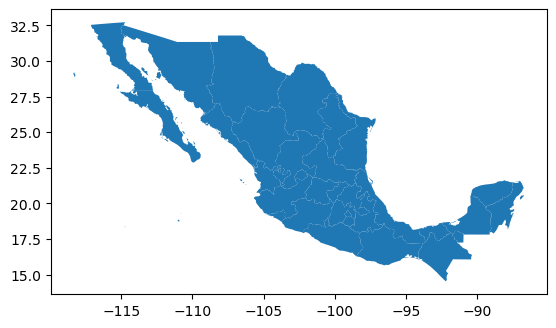

In [3]:
# Crear el DataFrame con la suma del PIB total por entidad y año
df_total = df_long.groupby(['Entidad', 'Año', 'Actividad económica']).sum().reset_index()
df_total = df_total[~df_total['Actividad económica'].str.startswith('Total')]


with open(r'D:\alex_\Documents\Programacion\Data Analysis\04 - PIB por actividad economica y estado\geojson-master\mexicoHigh.json') as f:
    mexico_geojson = json.load(f)

    
# Visualizar el archivo GeoJSON
gdf = gpd.GeoDataFrame.from_features(mexico_geojson['features'])

# Paso 3: Visualizar los datos
gdf.plot()

In [4]:
# Validar que los nombres de las entidades en el DataFrame coincidan con los nombres en el GeoJSON
for feature in mexico_geojson["features"]:
    name_geojson = feature["properties"]["name"]
    if name_geojson not in df_total["Entidad"].unique():
        print(f"El nombre '{name_geojson}' no se encuentra en el DataFrame.")
        
df_total["Entidad"].unique()

array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Chiapas', 'Chihuahua', 'Ciudad de México', 'Coahuila',
       'Colima', 'Durango', 'Guanajuato', 'Guerrero', 'Hidalgo',
       'Jalisco', 'Michoacán', 'Morelos', 'México', 'Nayarit',
       'Nuevo León', 'Oaxaca', 'Puebla', 'Querétaro', 'Quintana Roo',
       'San Luis Potosí', 'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas',
       'Tlaxcala', 'Total nacional', 'Veracruz', 'Yucatán', 'Zacatecas'],
      dtype=object)

In [5]:
# Iterar sobre las entidades en el GeoJSON
for feature in mexico_geojson["features"]:
    name_geojson = feature["properties"]["name"]
    id_geojson = feature["properties"]["id"]
    
    # Buscar el índice de la entidad en el DataFrame
    idx = df_total.index[df_total['Entidad'] == name_geojson]
    
    # Asignar el identificador al DataFrame si se encuentra la entidad
    if len(idx) > 0:
        df_total.loc[idx, 'id_geojson'] = id_geojson
        
df_total.head(5)

,Entidad,Año,Actividad económica,PIB,id_geojson
0,Aguascalientes,2010,Actividades primarias,5262.30,MX-AGU
1,Aguascalientes,2010,Actividades secundarias,43925.79,MX-AGU
2,Aguascalientes,2010,Actividades terciarias,72009.55,MX-AGU
4,Aguascalientes,2011,Actividades primarias,5186.67,MX-AGU
5,Aguascalientes,2011,Actividades secundarias,46551.13,MX-AGU


In [6]:

# Inicializar la aplicación Dash
app = dash.Dash(__name__)

# Definir las opciones del filtro (actividades económicas únicas)
actividades_economicas = [{'label': actividad, 'value': actividad} for actividad in df_total['Actividad económica'].unique()]

# Definir el layout de la aplicación
app.layout = html.Div([
    html.H1("Mapa Coroplético del PIB por Actividad Económica"),
    dcc.Dropdown(
        id='actividad_economica_dropdown',
        options=actividades_economicas,
        value=actividades_economicas[0]['value'],  # Valor predeterminado: primera actividad económica
        clearable=False,
        searchable=False
    ),
    dcc.Graph(id='mapa')
])

# Definir la callback para actualizar el mapa cuando se seleccione una actividad económica
@app.callback(
    Output('mapa', 'figure'),
    [Input('actividad_economica_dropdown', 'value')]
)
def actualizar_mapa(actividad_economica):
    df_filtrado = df_total[df_total['Actividad económica'] == actividad_economica]
    
    
    fig = px.choropleth(df_filtrado, 
                    locations='id_geojson',
                    geojson=mexico_geojson, 
                    color='PIB',
                    hover_name='Entidad', 
                    animation_frame='Año',
                    locationmode='geojson-id',
                    featureidkey="id", 
                    hover_data={'Año': False, 'id_geojson': False, 'PIB': True, 'Entidad': False, 'PIB': ':.2f'},
                    color_continuous_scale=px.colors.sequential.Plasma)
    
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(title=f"PIB por {actividad_economica}")
    return fig


# Ejecutar la aplicación Dash
if __name__ == '__main__':
    app.run_server(debug=True)